In [1]:
import torch
import cv2
import imageio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
import warnings
from demo import make_animation,relative_kp,get_keypoints
from skimage import img_as_ubyte
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
dataset_name = 'vox' # ['vox', 'taichi', 'ted', 'mgif']
source_image_path = './assets/baseframe.jpg'
driving_video_path = './assets/live_video_1.mp4'
output_video_path = './generated.mp4'
config_path = 'config/vox-256.yaml'
checkpoint_path = 'config/vox.pth.tar'
predict_mode = 'relative' # ['standard', 'relative', 'avd']
find_best_frame = False # when use the relative mode to animate a face, use 'find_best_frame=True' can get better quality result
pixel = 256

In [3]:
source_image = imageio.imread(source_image_path)
reader = imageio.get_reader(driving_video_path)


source_image = resize(source_image, (pixel, pixel))[..., :3]

fps = reader.get_meta_data()['fps']
reader.close()

#driving_video = [resize(frame, (pixel, pixel))[..., :3] for frame in driving_video]

**Create a model and load checkpoints**

In [4]:
from demo import load_checkpoints
inpainting, kp_detector, dense_motion_network, avd_network = load_checkpoints(config_path = config_path, 
                                                                              checkpoint_path = checkpoint_path, 
                                                                              device = device)

In [5]:
cam=cv2.VideoCapture(driving_video_path)
base_frame=cv2.imread(source_image_path)
base_frame=resize(base_frame,(512,512))
kp_source = get_keypoints(base_frame,kp_detector,device)
kp_driving_initial=kp_source
base_frame=torch.tensor(base_frame[np.newaxis].astype(np.float32)).permute(0, 3, 1, 2)
base_frame = base_frame.to(device)

-1


In [6]:
image=source_image
frame = torch.tensor(image[np.newaxis].astype(np.float32)).permute(0, 3, 1, 2)
frame=np.transpose(frame.detach().cpu().numpy(), [0, 2, 3, 1])[0]*255
frame=frame.astype(np.uint8)

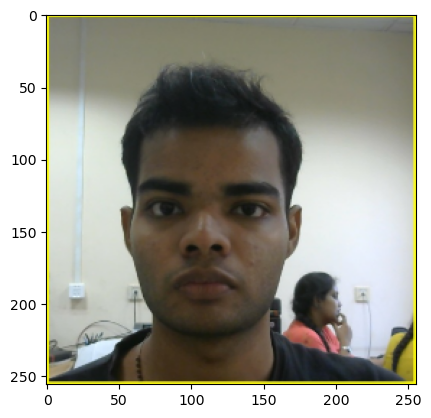

In [7]:
plt.imshow(frame)

In [8]:
tic=time.time()
key_points=[]
with torch.no_grad():
    while cam.isOpened():
        ret,frame=cam.read()
        if ret:
            frame=cv2.flip(frame,1)
            h,w,c=frame.shape
            cv2.rectangle(frame, ((w-h)//2,0), ((w+h)//2,h), (0,255,255), 5)
            driving_frame=frame[:,(w-h)//2:(w+h)//2,[2,1,0]]
            driving_frame=resize(driving_frame,(256,256))[...,:3]   
            kp_driving=get_keypoints(driving_frame,kp_detector,device)
            key_points.append(kp_driving)
        else:
            break 
toc=time.time()
cam.release()
toc-tic

torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([100, 2])
torch.Size([1

51.22910451889038

In [9]:
tic=time.time()
predictions=[]
with torch.no_grad():
    for i in tqdm(range(len(key_points))):   
        kp_driving=key_points[i]
        kp_norm = relative_kp(kp_source=kp_source, kp_driving=kp_driving,kp_driving_initial=kp_driving_initial)
        dense_motion = dense_motion_network(source_image=base_frame, kp_driving=kp_norm, kp_source=kp_source, bg_param = None, dropout_flag = False)
        out = inpainting(base_frame, dense_motion)
        predictions.append(np.transpose(out['prediction'].data.cpu().numpy(), [0, 2, 3, 1])[0])
toc=time.time()
print(toc-tic)
imageio.mimsave(output_video_path, [img_as_ubyte(frame) for frame in predictions], fps=fps)

  0%|                                                                                          | 0/381 [00:00<?, ?it/s]


RuntimeError: shape '[11, 128, 128, -1]' is invalid for input of size 688128

In [ ]:
predictions = make_animation(source_image, driving_video, inpainting, kp_detector, dense_motion_network, avd_network, device = device, mode = predict_mode)

#save resulting video
imageio.mimsave(output_video_path, [img_as_ubyte(frame) for frame in predictions], fps=fps)